## The scope of this notebook is to implement an approach to accelerate content editor's decision making through a top artist feature and most importantly demonstrate how NLP's Entity Resolution for semantically-equivalent naming bring improvement.
### 1. Build a new feature/dataset to accelerate artist recommendation.
### 2. Analyzing impact of named entity resolution on recommendation.

In [4]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data_dir = f"{os.getcwd()}/data"

In [6]:
df = pd.read_csv(f"{data_dir}/spotify_dataset.csv",
                    skiprows=1,
                    names=['user_id', 'artistname', 'trackname', 'playlistname'],
                    on_bad_lines='skip')
df = df.sample(n=10000, random_state=42)
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 7578551 to 10128040
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       10000 non-null  object
 1   artistname    9970 non-null   object
 2   trackname     10000 non-null  object
 3   playlistname  9999 non-null   object
dtypes: object(4)
memory usage: 390.6+ KB
None


,user_id,artistname,trackname,playlistname
7578551,5c2b840d66d02ac7aa6a069eddd17f48,Spice Girls,Wannabe - Radio Edit,Lol HiGh Sk00l MeMorIeZ
911963,6da651f45aac18e5da52433aa3c38947,Flying Lotus,Descent Into Madness (feat. Thundercat),Best of 2014
8049506,20350023c94899ce25cd1a86ea385853,Kristin Hersh,Your Ghost,Ladies. All the ladies.
11247838,f9809d1afbab1b0aaa0c2f678a90752a,Rotary Connection,This Town,To listen to
6160700,db9646b77f3a677040b9140489da16f1,Bastille,Pompeii,Starred


In [ ]:
#### 

In [7]:
df.describe()

,user_id,artistname,trackname,playlistname
count,10000,9970,10000,9999
unique,5019,5696,9347,6640
top,4398de6902abde3351347b048fcdc287,The Rolling Stones,Mercy,Starred
freq,210,28,6,1017


In [8]:
df.isnull().sum()

user_id          0
artistname      30
trackname        0
playlistname     1
dtype: int64

In [9]:
df[df['artistname'].isnull()]

,user_id,artistname,trackname,playlistname
10582452,9b0cb216778138cc481d17dee58a0319,NaN,avicii vs nicky romero - i could be the one (n...,Bautizo
10366650,93000d9cad22c61869db84fb96c8b5c9,NaN,Animal Crossing New Leaf - 12 PM (Extended),Animal Crossing
8186225,c8e0b3f55f4ecd3c0c7947a18e7472d8,NaN,16 - Joni Mitchell - Both Sides Now - www.torr...,MMM
3642727,74bc80e9a16ccd15a85f8d4d871000cf,NaN,Gee - SNSD,Osu!
8516423,67bb38768667210fe57b985c96f5fa4c,NaN,Ben Pearce - What I Might Do (Kilter Remix),1 wintah starred 14'
7512326,c738ccdf6921c156a815e9fa9f8b9dd9,NaN,Spor 08,BCN 06
7827501,2801dbeaa27d88758fc964e70b64f7bc,NaN,Gonzales - Z - 13 - Let's Groove Again ft. Lou...,Gregory Gray’s iPod Selection
6767682,c6f591538735f1c7c25964edfcbe81b8,NaN,Dio - Holy Diver - drumless,drumless
1447006,cba662ee7038612852220efd5730e616,NaN,Kaleido Star Op2,Anime
5036191,14d4bc2cb64c89d7180421e93afc271a,NaN,16 ANOCHECE.mp3,musica


In [10]:
df.dropna(inplace=True)

In [11]:
# duplicates
df[df.duplicated()]

,user_id,artistname,trackname,playlistname


##### this dataset doesn't provide repeat of track/s, but merely tracks that have been played, playlist and artist track belongs to. 
## We can learn more about user-artist preference. 

In [19]:
# artist frequently played by userid
df.groupby(['user_id', 'artistname'], as_index=False
          )['artistname'].count().sort_values(by=['artistname'], ascending=False)

,user_id,artistname
5566,8c3e1191cb28f7c57bbf35c1e2ad1bf1,5
1422,26b51e580277e131f87e4c7ee4c0887a,5
9620,fa6ec384798989855ad898e6b8c68c3b,4
2471,414050deadb38aafd8d4ad22ca634055,4
6422,a251c8204b5bc479dc5c83c15b7cc929,3
...,...,...
3293,53f433aeae7d61e5e977a61342a92740,1
3294,54174df459c3780a3251a9ce6506db09,1
3295,541a9ceaaf98e45954894532ec57f30b,1
3296,543d13a267c4f91c511fdaf97a13f86b,1


In [20]:
# artist's track in total playlist
df.groupby(['artistname', "trackname"], as_index=False
          )['playlistname'].nunique().sort_values(by=['playlistname'], ascending=False)

,artistname,trackname,playlistname
2641,Eminem,Lose Yourself - Soundtrack Version,4
7030,Rihanna,We Found Love,4
615,Avicii,Hey Brother,4
7076,Robin Thicke,Blurred Lines,4
5735,Modest Mouse,Float On,4
...,...,...,...
3257,Good Knight Productions,Sonic Adventure 2 - Way to the Base,1
3258,Goran Bregovic,RUŽICA,1
3259,Gordon Lightfoot,Beautiful,1
3260,Gorguts,Le toit du monde,1


In [21]:
# artist in a playlist
df.groupby(['playlistname'], as_index=False
          )['artistname'].nunique().sort_values(by=['artistname'], ascending=False)

,playlistname,artistname
4739,Starred,868
2955,Liked from Radio,130
1874,Favoritas de la radio,26
201,2013,23
1198,Christmas,20
...,...,...
2363,How To Dress Well – Total Loss,1
2362,How To Disappear Completely,1
2361,How I Met Your Mother (music from the show),1
2360,House on SOUNDROP,1


In [22]:
df.groupby(['artistname', "playlistname"], as_index=False
          )['trackname'].nunique().sort_values(by=['trackname'], ascending=False)

,artistname,playlistname,trackname
9227,Vitamin String Quartet,Vitamin String Quartet,10
1722,Coldplay,Coldplay,8
3793,JAY Z,Starred,6
6618,Pink Floyd,Starred,5
6827,Radiohead,Starred,5
...,...,...,...
3250,Good Knight Productions,Good Knight Productions – Sonic The Hedgehog V...,1
3251,Goran Bregovic,Goran Bregovic - ALKOHOL ŠLJIVOVICA & CHAMPAGNE,1
3252,Gordon Lightfoot,Classic Rock,1
3253,Gorguts,Hårda Top 30 Listan 2013,1


## Preprocessing artist name 

##### text normalization

In [23]:
import re
# Function to normalize text
def normalize(text):
    text = text.lower() 
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r"[.'’]", '', text)  # Remove punctuation
    text = re.sub(r'^(the|a)\s+', '', text) # Remove the, a from start of the text
    return text

# Normalize all artist names
df['normalized_artistname'] = df['artistname'].apply(normalize)
df

,user_id,artistname,trackname,playlistname,normalized_artistname
7578551,5c2b840d66d02ac7aa6a069eddd17f48,Spice Girls,Wannabe - Radio Edit,Lol HiGh Sk00l MeMorIeZ,spice girls
911963,6da651f45aac18e5da52433aa3c38947,Flying Lotus,Descent Into Madness (feat. Thundercat),Best of 2014,flying lotus
8049506,20350023c94899ce25cd1a86ea385853,Kristin Hersh,Your Ghost,Ladies. All the ladies.,kristin hersh
11247838,f9809d1afbab1b0aaa0c2f678a90752a,Rotary Connection,This Town,To listen to,rotary connection
6160700,db9646b77f3a677040b9140489da16f1,Bastille,Pompeii,Starred,bastille
...,...,...,...,...,...
4892779,529f12438bfbfc2c67a15cb1bc915e26,Agaric,No Way I Know I Feel - Axel Boman Remix,Ovum Recordings,agaric
9544566,ce1ac1277e6abbe4b232f8e92b83fbdf,2Pac,Got My Mind Made Up,truckin,2pac
2682421,4cecda8e0ebdcc4c664aa3598a35c43b,James Curd,A Friend,NuDisco/ObscureDisco/House/DeepHouse/IndieDance,james curd
11586113,658159ed7b84bf407b1edd7bf7ce30c8,DJ Jump,On My Own,Various Artists – 101 Baladas del Pop,dj jump


##### semantically-equivalent name

In [97]:
import difflib
def cleanup_dict(equivalent_names):
    new_equivalent_names = {}
    repeatative_names = []
    for k, v in equivalent_names.items():
        if k in repeatative_names:
            continue
        new_equivalent_names[k] = v
        repeatative_names.extend(v)
    return new_equivalent_names

def find_equivalent_names(list_artists):
    equivalent_names = {}
    for artist in list_artists:
        matches = difflib.get_close_matches(artist, list_artists, 
                                            n=5, cutoff=0.7
                                           ) #manage cutoff to get closest match based on requirement
        if len(matches) > 1:
            equivalent_names[artist] = matches
    return equivalent_names

equivalent_artist_names = cleanup_dict(
                            find_equivalent_names([str(n) for n in df['normalized_artistname'].unique()])
                        )

# print first 30 items from dictionary
i = 0
for k, v in equivalent_artist_names.items():
    print(k, v)
    i += 1
    if i == 30:
        break

spice girls ['spice girls', 'cheap girls']
kristin hersh ['kristin hersh', 'kristin chenoweth']
bastille ['bastille', 'stills', 'ballet', 'bagatelle']
skillet ['skillet', 'skrillex', 'killers']
since october ['since october', 'spin doctors', 'blue october']
linkin park ['linkin park', 'clinton sparks']
blur ['blur', 'blu', 'blue']
16volt ['16volt', '16 volt']
crystal castles ['crystal castles', 'crystal stilts', 'crystal fighters']
hives ['hives', 'givers']
andrew bird ['andrew bird', 'andrew ripp', 'andrew gold', 'new breed']
bongwater ['bongwater', 'ben walther']
bravery ['bravery', 'ralvero']
train ['train', 'trini', 'travis', 't-pain', 't pain']
snow patrol ['snow patrol', 'soul patrol']
black books ['black books', 'bad books', 'black rose', 'black kids', 'black keys']
future islands ['future islands', 'futureheads']
cars ['cars', 'mc lars', 'caesars']
soundgarden ['soundgarden', 'sound nomaden']
ryan adams ['ryan adams', 'bryan adams']
rancid ['rancid', 'acid', 'ramoncin']
dash be

In [25]:
# Identified artistnames that are semantically equivalent and so can be merged into a single named entity.
semantically_equivalent_artistnames = {'16 volt':'16volt',
 '30 seconds to mars':'thirty seconds to mars',
  'various artists - abba tribute': 'various artists - the eagles tribute',
 'b dylan': 'bob dylan',
 'dave matthews':'dave matthews band',
 'bjork': 'björk',
 'jay z': 'jay-z',
 'paul mccartney & wings':'paul mccartney',
  'original motion picture soundtrack':'motion city soundtrack',
 'macklemore & ryan lewis ft mary lambert': 'macklemore & ryan lewis',
 'imogen heap':'imagen heap',
 'pat metheny group':'pat metheny',
 'guns and roses':'guns n roses', 
 'belle & sebastian':'belle and sebastian',
  'sylvan':'sylvan esso',
 'william fitzsimmons & michael flynn':'william fitzsimmons',
'drumsound & bassline smith': 'drumsound & bassline',
 'oscar de leon' : 'oscar dleón',
 'london symphony orchestra': 'london philharmonic orchestra',
  'relaxing piano music': 'relaxing piano music consort', 
 'florence + the machine': 'florence and the machine',
 'hans zimmer & james newton howard': 'james newton howard',
 'led zepagain': 'led zeppelin',
 'coheed & cambria': 'coheed and cambria',
 'beyonce': 'beyonce ft jay z',
 'beyonce': 'beyonce feat kanye west',
 'simon & garfunkel': 'simon and garfunkel', 
 'oscar peterson trio': 'oscar peterson',
 'dave brubeck':'dave brubeck quartet',
 'rocío dúrcal': 'rocio durcal',  
 'joaquin sabina':'joaquín sabina',
 'ray barretto': 'ray barreto',
 'kenny garrett quintet': 'kenny garrett',
 'elvis costello ' : 'elvis costello and the brodsky quartet',
 'elvis costello' : 'elvis costello & the imposters',
 'elvis costello' : 'elvis costello & the attractions',
}

In [26]:
# Replace artistname to it's semantically equivalent. Reducing noise
df['semantical_equivalent_normalized_artistname'] = df['normalized_artistname'].apply(
    lambda x: semantically_equivalent_artistnames[x] if x in semantically_equivalent_artistnames else x
                                                                       )
df

,user_id,artistname,trackname,playlistname,normalized_artistname,semantical_equivalent_normalized_artistname
7578551,5c2b840d66d02ac7aa6a069eddd17f48,Spice Girls,Wannabe - Radio Edit,Lol HiGh Sk00l MeMorIeZ,spice girls,spice girls
911963,6da651f45aac18e5da52433aa3c38947,Flying Lotus,Descent Into Madness (feat. Thundercat),Best of 2014,flying lotus,flying lotus
8049506,20350023c94899ce25cd1a86ea385853,Kristin Hersh,Your Ghost,Ladies. All the ladies.,kristin hersh,kristin hersh
11247838,f9809d1afbab1b0aaa0c2f678a90752a,Rotary Connection,This Town,To listen to,rotary connection,rotary connection
6160700,db9646b77f3a677040b9140489da16f1,Bastille,Pompeii,Starred,bastille,bastille
...,...,...,...,...,...,...
4892779,529f12438bfbfc2c67a15cb1bc915e26,Agaric,No Way I Know I Feel - Axel Boman Remix,Ovum Recordings,agaric,agaric
9544566,ce1ac1277e6abbe4b232f8e92b83fbdf,2Pac,Got My Mind Made Up,truckin,2pac,2pac
2682421,4cecda8e0ebdcc4c664aa3598a35c43b,James Curd,A Friend,NuDisco/ObscureDisco/House/DeepHouse/IndieDance,james curd,james curd
11586113,658159ed7b84bf407b1edd7bf7ce30c8,DJ Jump,On My Own,Various Artists – 101 Baladas del Pop,dj jump,dj jump


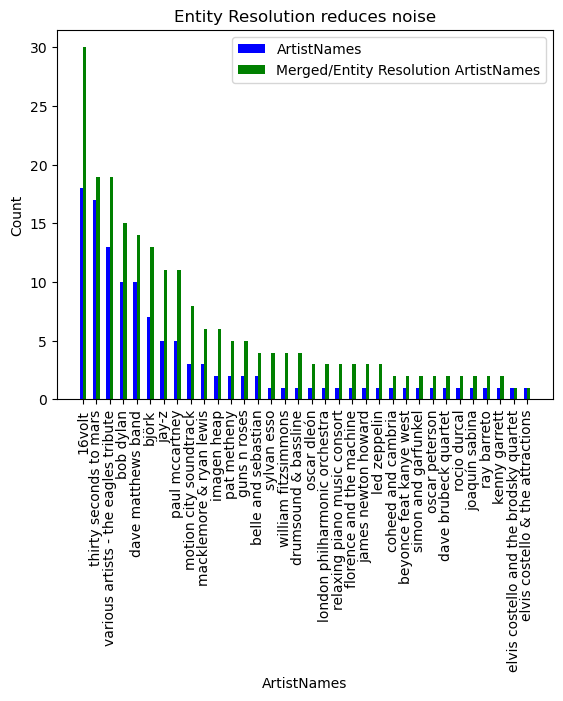

In [32]:
labels_artistname = semantically_equivalent_artistnames.values()

artist_counts = df['normalized_artistname'][
    df['normalized_artistname'].isin(labels_artistname)].value_counts()

ner_artist_counts = df['semantical_equivalent_normalized_artistname'][
    df['semantical_equivalent_normalized_artistname'].isin(labels_artistname)].value_counts()

r = np.arange(len(labels_artistname)) 
width = 0.25
plt.bar(r , artist_counts.tolist(), color='b', width = width, label='ArtistNames')
plt.bar(r + width, ner_artist_counts.tolist(), color='g', width = width, label='Merged/Entity Resolution ArtistNames')

plt.xticks(r + width/2, labels_artistname, rotation=90)
plt.xlabel('ArtistNames')
plt.ylabel('Count')
plt.title('Entity Resolution reduces noise')
plt.legend() 
plt.show()

## User-Artist Interaction Matrix

In [34]:
# named entity resolution - user artist matrix 
user_artist_ner_matrix = df.groupby(['user_id', 'semantical_equivalent_normalized_artistname']
                               )['semantical_equivalent_normalized_artistname'].count().unstack().reset_index().fillna(0)
user_artist_ner_matrix.set_index('user_id', inplace=True)

# user artist matrix 
user_artist_matrix = df.groupby(['user_id', 'normalized_artistname']
                               )['normalized_artistname'].count().unstack().reset_index().fillna(0)
user_artist_matrix.set_index('user_id', inplace=True)                             

In [35]:
print(f"Applying Named Entity Resolution reduces dimensionality {len(user_artist_matrix.columns)}\
 to {len(user_artist_ner_matrix.columns)} ")

Applying Named Entity Resolution reduces dimensionality 5665 to 5633 


##### Techniques like K-means, DBScan will not yield meaningful result with sparse feature unless we further apply dimensionality reduction.
## User-based collaborative filtering

In [87]:
from sklearn.metrics.pairwise import cosine_similarity

similar_users_dict = {}

def user_cosine_similarity(user_artist_matrix):
    
    # Compute the cosine similarity between users
    user_similarity = cosine_similarity(user_artist_matrix)
    # Create a DataFrame for user similarity
    df_user_similarity = pd.DataFrame(user_similarity, index=user_artist_matrix.index, columns=user_artist_matrix.index)
    return df_user_similarity

def recommend_top_artists(user_id, df_user_similarity, user_artist_matrix, similar_users = 5, top_artist = 10):
    def get_top_n_similar_users(user_id, n):
        list_similar_users = df_user_similarity[user_id].sort_values(ascending=False).head(n+1).index.tolist()
        if user_id in list_similar_users:
            list_similar_users.remove(user_id)
            
        return list_similar_users
    
    list_similar_users = get_top_n_similar_users(user_id, similar_users)
    artist_scores = user_artist_matrix.loc[list_similar_users].mean(axis=0)
    top_artists = artist_scores.sort_index().sort_values(ascending=False).head(top_artist).index.tolist()
    return list_similar_users, top_artists


user_id = '0025022960e5f0d7d01af5d840014594'
matrix = user_artist_matrix
list_similar_users, top_artists = recommend_top_artists(user_id, user_cosine_similarity(matrix), matrix,
                                    similar_users = 5, top_artist = 3
                                   )
print(f"Top 10 artist recommendations for user {user_id}: {top_artists}")

Top 10 artist recommendations for user 0025022960e5f0d7d01af5d840014594: ['robbie williams', 'english chamber orchestra, conducted by jeffrey tate', 'jethro tull']


#### Example : Analyze difference in recommendation vs NER recommandation

In [92]:
user_id = '5c2b840d66d02ac7aa6a069eddd17f48'
top_artist = 5
similar_users = 5

matrix = user_artist_matrix
list_similar_users, top_artists = recommend_top_artists(user_id, user_cosine_similarity(matrix), matrix,
                                    similar_users = similar_users, top_artist = top_artist
                                   )
print(f"Top {top_artist} artist recommendations for user {user_id} : \n {top_artists} \n")
print(f"Top {similar_users} similar users {list_similar_users} \n")
for u in list_similar_users:
    print(f"\t Artist frequented by {u}:\
            {user_artist_matrix.loc[u].sort_index().sort_values(ascending=False).head(top_artist).index.tolist()} ")

    
print('\n')
print('---------------- Improved Recommendation with Entity Resolution ---------------------------------------------- \n')
matrix = user_artist_ner_matrix
list_similar_users_ner, top_artists_ner = recommend_top_artists(user_id, user_cosine_similarity(matrix), matrix,
                                    similar_users = similar_users, top_artist = top_artist
                                   )
print(f"Top {top_artist} NER artist recommendations for user {user_id} : \n {top_artists_ner} \n")
print(f"Top {similar_users} similar users {list_similar_users_ner} \n")
for u in list_similar_users_ner:
    print(f"\t Artist frequented by {u}: \
        {user_artist_ner_matrix.loc[u].sort_index().sort_values(ascending=False).head(top_artist).index.tolist()}")


Top 5 artist recommendations for user 5c2b840d66d02ac7aa6a069eddd17f48 : 
 ['spice girls', 'jay-z', 'jack johnson', 'lil wayne', 'pretty lights'] 

Top 5 similar users ['7017180d62cb57488fc8bb058b3c3a8e', '4fe4a15f91a6ac37af77dfee99e11957', '01ad7fc79498ab698b3f0e0f2c5c818e', 'ac08669f9d162aea8a4c599f311ef979', 'abfe2c0cc529a4cf5513604c1e422e83'] 

	 Artist frequented by 7017180d62cb57488fc8bb058b3c3a8e:            ['spice girls', '+/-', 'ne-yo', 'naughty by nature', 'naughty boy'] 
	 Artist frequented by 4fe4a15f91a6ac37af77dfee99e11957:            ['fleetwood mac', 'spice girls', '+/-', 'ne-yo', 'naughty by nature'] 
	 Artist frequented by 01ad7fc79498ab698b3f0e0f2c5c818e:            ['pretty lights', 'avicii', 'lil wayne', 'glee cast', 'deadmau5'] 
	 Artist frequented by ac08669f9d162aea8a4c599f311ef979:            ['mumford & sons', '+/-', 'natalie imbruglia', 'ndidi o', 'naughty by nature'] 
	 Artist frequented by abfe2c0cc529a4cf5513604c1e422e83:            ['jerry lee lewis', 'c

#### get top artist recommendation for all users

In [89]:
user_top_artists_recommendation = {}

df_user_cosine_similarity = user_cosine_similarity(user_artist_matrix)

df_user_ner_cosine_similarity = user_cosine_similarity(user_artist_ner_matrix)

similar_users = 5
top_artist = 3
for user_id in df.user_id:
    user_top_artists_recommendation[user_id] = []
    list_similar_users, top_artists = recommend_top_artists(user_id, df_user_cosine_similarity, user_artist_matrix,
                                    similar_users = similar_users, top_artist = top_artist 
                                   )
    user_top_artists_recommendation[user_id].append(top_artists)
    
    # ner 
    list_similar_users, top_ner_artists = recommend_top_artists(user_id, df_user_ner_cosine_similarity, user_artist_ner_matrix,
                                similar_users = similar_users, top_artist = top_artist 
                               )
    user_top_artists_recommendation[user_id].append(top_ner_artists)

In [90]:
df_top_artist_recommendation = pd.DataFrame.from_dict(user_top_artists_recommendation,orient='columns').transpose()
df_top_artist_recommendation.columns=['top artist','Entity Resolution - top artist']

df_top_artist_recommendation.head(50)

,top artist,Entity Resolution - top artist
5c2b840d66d02ac7aa6a069eddd17f48,"[spice girls, jay-z, jack johnson]","[spice girls, pretty lights, jack johnson]"
6da651f45aac18e5da52433aa3c38947,"[flying lotus, miles davis, minutemen]","[flying lotus, miles davis, minutemen]"
20350023c94899ce25cd1a86ea385853,"[robbie williams, english chamber orchestra, c...","[robbie williams, sufjan stevens, johann sebas..."
f9809d1afbab1b0aaa0c2f678a90752a,"[arcade fire, nine inch nails, john butler trio]","[arcade fire, nine inch nails, john butler trio]"
db9646b77f3a677040b9140489da16f1,"[bastille, +/-, natalie grant]","[bastille, +/-, natalie dessay/le concert d`as..."
7ee6797934d627b54a72dda785b1ea85,"[dinosaur jr, jack white, jerry goldsmith]","[dinosaur jr, sufjan stevens, tame impala]"
5c4438bac13e50d6db5058ad0b0983da,"[joni mitchell, jamie cullum, alt-j]","[joni mitchell, sandy denny, alt-j]"
705e46c3ff12a665e14ab67c497f18ac,"[rolling stones, ella fitzgerald, mannheim ste...","[rolling stones, ella fitzgerald, mannheim ste..."
ec4faa478b43b87aa990f5f2b7d0f414,"[nine inch nails, beck, frank zappa]","[nine inch nails, beck, frank zappa]"
500e8b67136775d227d35a1bb37478aa,"[awolnation, darkside, clint mansell]","[awolnation, first aid kit, darkside]"


In [91]:
print('Total Users' , len(df_top_artist_recommendation.index))

per_users_artist_recom_impacted = round(len(
                                    np.where(
                                        (df_top_artist_recommendation['top artist'] != df_top_artist_recommendation['Entity Resolution - top artist'])
                                    )[0])*100/len(df_top_artist_recommendation.index),2)

print()
print('--------------------------------------------------------------------------- \n ')
print(f"\t {per_users_artist_recom_impacted}% user's recommendation affected with Entity Resolution")
print('\n---------------------------------------------------------------------------')

Total Users 5009

--------------------------------------------------------------------------- 
 
	 80.93% user's recommendation affected with Entity Resolution

---------------------------------------------------------------------------


# ------------------------------------------------------------------------------------------

### Next steps or challenges:
#### - Limited data. Data Collection like 
    1. Content data 
        song metadata such as release year and duration
        attributes of songs such as tempo, key, loudness, modesuch as tempo, genre, mood
    
    2. User data
        interaction data: skips, likes, dislikes, shares, and playlist additions.
        search queries: search terms users use to find music.
##### - Working with larger volume of data. 
##### - Editorial input in artist name - text normalization would further improve this feature thereby model's performance
